# <center>Chat messages and matchmaking</center>

## <center>Finding the perfect match using text classification on my own message history</center>

### <center>Pavel Bogdanov - Software University</center>

### Abstract

We explore the messages from Facebook's "Download your data" section and try to find useful information for text classification. We extract all the links, emoticons, emojis and we separate words into three different categories - English, Bulgarian, and Bulgarian written in latin. All words are checked for validity in a wordlist and processed by transliterating, stemming and stopwords elimination. Multinomial naive bayes is used for classifying messages by sender name and deliberately missclassificating my own messages as another sender.

### 1 Introduction

Have you ever wondered what kind of information does Facebook have on you? What kind of amazing data science they could be making? Wonder no more! Facebook gives us the option to download all of our data into the machine-friendly JSON format. This is done by going to your Settings -> Your Facebook Information -> Download Your Information. Once there, you can select the type of information you want, the period for which you want it and if you prefer you can select HTML as a format for the files. We will select only the "messages" checkbox but unfortinately we can't not download the media files as well, so we will select the Media Quality to "Low". Be aware that after we send our request to Facebook it might take sveral hours untill we receive a link to download the data, especially if you selected ALL of your data. My original "messages" folder was 4,48 GB but by deleting all the pictures/videos/audio files and leaving only the JSONs I was left with a total size of 101 MB. Of course, I also anonymized all of the names so I can show you my results, but other than that, this notebook should work with eny other person's data. So if you want to learn more about yourself or your friends, give it a go.

What is our main objective here? Well, we want to find who is our best match. What does that mean? It can mean a lot of things. Our best match can be someone who's writing style most closely resembles ours. Or it can be just the person we've texted with the most. Or it can be someone with whom we exchange a lot of emojis. We will explore all of the available options and the result can be something we expect, like our best friend or our romantc partner, or it can be someone with whom we didn't realise we shared so much in common. Let's find out.

### 2 Loading dependencies

In [1]:
ME = "Алексиа Таралингова"
# Change value to your own name if you want to try it out!

# Or use this if you're messing with the the anonymizator:
# >>> fake.seed(42)
# >>> ME = fake.name()

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import json
import glob
import re
from urllib.parse import urlparse
from collections import Counter
from functools import partial
from IPython.display import Audio

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import transliterate
from transliterate.contrib.languages.bg.translit_language_pack import BulgarianLanguagePack
from emoji import UNICODE_EMOJI
from wordcloud import WordCloud

from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

from bulstem import stem, MIN_WORD_LEN

### 3 Data acquisition

Pros of Facebook's data: It's not in HTML format.

Cons: Badly encoded, unnecessary media files, puts all the messages in different folders.

Let's write a function that reads a JSON file and converts it to a pandas dataframe.

In [4]:
def json_to_df(filepath, friend_name=True):
    """
    Reads facebook messenger's JSON file and returns a pandas Dataframe.
    
    Doesn't return a dataframe if the participants are more
    than two people(no group chats).
    
    Works only on the "Messages" json files downloaded through
    Facebook's "Download Your Information" section.
    
    Parameters
    ----------
    filepath : string
        Filepath to the JSON file.
    friend_name : boolean, default True
        If True, adds an aditional column "friend_name" to the df.
    Returns
    -------
    result : Dataframe        
    """
    # Fixes bad encoding
    fix_mojibake_escapes = partial(re.compile(rb'\\u00([\da-f]{2})').sub, lambda m: bytes.fromhex(m.group(1).decode()))
    
    # Need to read as binary to decode correctly
    with open(filepath, 'rb') as file:    
        repaired = fix_mojibake_escapes(file.read())
        data = json.loads(repaired.decode('utf8'), strict=False)
        
        # No group chats!
        if len(data['participants']) == 2:
            result = pd.DataFrame.from_dict(data['messages'])
            
            # Additional column
            if friend_name:
                participants = pd.Series(data['participants']).apply(pd.Series)
                for name in participants.name:
                    if not name == ME:
                        result['friend_name'] = name
            return result

And to read all the files from different folders simultaneously we can use the handy "glob" module.

In [5]:
all_files = glob.glob("messages/inbox/*/message_1.json")
data = pd.concat((json_to_df(filename) for filename in all_files), ignore_index=True, sort=False)

Let's check it out.

In [6]:
data.shape

(667746, 17)

In [7]:
data.tail()

,content,photos,reactions,sender_name,share,sticker,timestamp_ms,type,friend_name,files,call_duration,missed,audio_files,gifs,videos,plan,users
667741,Хубаво.,NaN,NaN,Алексиа Таралингова,NaN,NaN,1387305388712,Generic,Яцо Джогов,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
667742,goddamnit,NaN,NaN,Алексиа Таралингова,NaN,NaN,1387305386316,Generic,Яцо Джогов,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
667743,:DD,NaN,NaN,Яцо Джогов,NaN,NaN,1387305379731,Generic,Яцо Джогов,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
667744,"хахаха, само че не дописах, че няма как да дой...",NaN,NaN,Яцо Джогов,NaN,NaN,1387305376924,Generic,Яцо Джогов,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
667745,Добре дошла на борда,NaN,NaN,Алексиа Таралингова,NaN,NaN,1387305353904,Generic,Яцо Джогов,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 4 Data tidying and cleaning

So the first thing that immediately pops out is the `timestamp_ms` column.

In [8]:
data.timestamp_ms.dtype

dtype('int64')

First of all, we can't even make out what year it is, let alone the time of day. We need to transform it to a proper datetime format.

In [9]:
# At least they named the column descriptively 
data.timestamp_ms = pd.to_datetime(data.timestamp_ms, unit='ms')

In [10]:
data.timestamp_ms.head()

0   2018-12-31 22:36:34.976
1   2018-10-25 11:29:29.851
2   2018-10-25 09:31:36.198
3   2018-10-24 17:10:31.532
4   2018-10-24 17:10:28.140
Name: timestamp_ms, dtype: datetime64[ns]

Second, our dataframe is sorted by `friend_name` as this is the order the folders were sorted when we read the JSON files. We can sort the whole dataset by chronological order using the new datetime column.


In [11]:
data = data.sort_values('timestamp_ms')

In [12]:
data.timestamp_ms.head()

284072   2010-07-16 10:09:14
441879   2010-10-08 19:36:37
357312   2010-11-12 18:01:01
284071   2010-11-28 18:13:56
284070   2010-11-28 18:15:03
Name: timestamp_ms, dtype: datetime64[ns]

Third, all of the values in the timestamp column should be unique. That's a great candidate for a dataframe index.

In [13]:
len(data.timestamp_ms) == len(data.timestamp_ms.unique())

False

Okay, it seems not all of the values are unique...

In [14]:
data.timestamp_ms[data.timestamp_ms.duplicated()].count()

88

...but that's a small enough number for us to drop the duplicate rows and pretend like nothing happened.

In [15]:
data = data.drop_duplicates('timestamp_ms')

In [16]:
data = data.set_index('timestamp_ms', verify_integrity=True)

In [17]:
data.index.names = ['timestamp']

In [18]:
data.tail()

,content,photos,reactions,sender_name,share,sticker,type,friend_name,files,call_duration,missed,audio_files,gifs,videos,plan,users
timestamp,,,,,,,,,,,,,,,,
2019-07-22 15:09:15.928,"добре, чакай сега недей да пишеш за известно в...",NaN,NaN,Алексиа Таралингова,NaN,NaN,Generic,Ирник Топчийски,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-07-22 15:09:31.911,some English text 123 wohoo yeaaah !!! xD,NaN,NaN,Алексиа Таралингова,NaN,NaN,Generic,Ирник Топчийски,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-07-22 15:09:36.887,NaN,NaN,NaN,Ирник Топчийски,NaN,{'uri': 'messages/stickers_used/39178562_15051...,Generic,Ирник Топчийски,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-07-22 15:09:55.550,sh1okavica bum bam nqkvi dumi,NaN,NaN,Алексиа Таралингова,NaN,NaN,Generic,Ирник Топчийски,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-07-22 15:10:12.635,Данчо е супер пич 😎,NaN,NaN,Алексиа Таралингова,NaN,NaN,Generic,Ирник Топчийски,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


That's better, but what's up with the rest of the columns?

Let's check if they contain some useful information or we can get rid of them.

In [19]:
data.type.value_counts()

Generic        662518
Share            4965
Call              160
Unsubscribe         7
Subscribe           4
Plan                4
Name: type, dtype: int64

We can see that the majority of the content is of `type` "Generic". These are all the normal text messages we want, but what about the "Share" type?

In [20]:
data[data.type=='Share'].head()

,content,photos,reactions,sender_name,share,sticker,type,friend_name,files,call_duration,missed,audio_files,gifs,videos,plan,users
timestamp,,,,,,,,,,,,,,,,
2010-07-16 10:09:14.000,http://www.youtube.com/watch?v=McTp7tw_a10&pla...,NaN,NaN,Алексиа Таралингова,{'link': 'http://gdata.youtube.com/feeds/api/v...,NaN,Share,Г-ца Найчо Овнарски,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-10-08 19:36:37.000,То си имало специална страница за твоя проблем...,NaN,NaN,Алексиа Таралингова,{'link': 'http://www.facebook.com/help/identif...,NaN,Share,Дениандра Таралингова,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-12-05 22:32:28.000,Виж как Сашко и Тео си играят докато бяха у нас,NaN,NaN,Алексиа Таралингова,{'link': 'http://gdata.youtube.com/feeds/api/v...,NaN,Share,Зинови Станишев,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-03-16 19:17:24.000,Субтитри http://subs.sab.bz/index.php?s=c89853...,NaN,NaN,Алексиа Таралингова,{'link': 'http://subs.sab.bz/index.php?s=c8985...,NaN,Share,Евтим Фенеров,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-11-11 11:54:08.555,Абе Янко...Skyrim и Elder Scrolls V е едно и с...,NaN,NaN,Алексиа Таралингова,{'link': 'http://www.zamunda.net/details.php?i...,NaN,Share,Евтим Фенеров,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


It looks like these are all the messages containing a link. Also there is some more information in the `share` column, but we will explore this later. For now we can get rid of all the stuff we don't need.

In [21]:
mess = data[(data.type=='Generic') | (data.type=='Share')][['sender_name', 'content', 'friend_name', 'type', 'share', 'reactions']]

In [22]:
mess.content.dropna(inplace=True)

And transform the categorical columns into an actual type "category".

In [23]:
mess.dtypes

sender_name    object
content        object
friend_name    object
type           object
share          object
reactions      object
dtype: object

In [24]:
mess.sender_name = mess.sender_name.astype('category')
mess.friend_name = mess.friend_name.astype('category')
mess.type = mess.type.astype('category')

In [25]:
mess.dtypes

sender_name    category
content          object
friend_name    category
type           category
share            object
reactions        object
dtype: object

In [26]:
mess.tail()

,sender_name,content,friend_name,type,share,reactions
timestamp,,,,,,
2019-07-22 15:09:15.928,Алексиа Таралингова,"добре, чакай сега недей да пишеш за известно в...",Ирник Топчийски,Generic,NaN,NaN
2019-07-22 15:09:31.911,Алексиа Таралингова,some English text 123 wohoo yeaaah !!! xD,Ирник Топчийски,Generic,NaN,NaN
2019-07-22 15:09:36.887,Ирник Топчийски,NaN,Ирник Топчийски,Generic,NaN,NaN
2019-07-22 15:09:55.550,Алексиа Таралингова,sh1okavica bum bam nqkvi dumi,Ирник Топчийски,Generic,NaN,NaN
2019-07-22 15:10:12.635,Алексиа Таралингова,Данчо е супер пич 😎,Ирник Топчийски,Generic,NaN,NaN


Looks like there's still some NaN columns even after we used `dropna()`. No problem, we can fix that.

In [27]:
mess.content = mess.content.str.lower()
mess.content = mess.content.replace(np.nan, '0')
mess = mess[mess.content!='0']

In [28]:
mess.tail()

,sender_name,content,friend_name,type,share,reactions
timestamp,,,,,,
2019-07-22 15:08:48.294,Ирник Топчийски,ако мн го закъсаш с събирането на съобщенията ...,Ирник Топчийски,Generic,NaN,NaN
2019-07-22 15:09:15.928,Алексиа Таралингова,"добре, чакай сега недей да пишеш за известно в...",Ирник Топчийски,Generic,NaN,NaN
2019-07-22 15:09:31.911,Алексиа Таралингова,some english text 123 wohoo yeaaah !!! xd,Ирник Топчийски,Generic,NaN,NaN
2019-07-22 15:09:55.550,Алексиа Таралингова,sh1okavica bum bam nqkvi dumi,Ирник Топчийски,Generic,NaN,NaN
2019-07-22 15:10:12.635,Алексиа Таралингова,данчо е супер пич 😎,Ирник Топчийски,Generic,NaN,NaN


### 5 Data visualization. Exploratory data analysis

Our main source of data is the `content` column but that doesn't mean we can't get some useful information from the other, less important columns.

Let's see what we have.

#### 5.1 Reactions

In [29]:
mess[mess.reactions.notnull()].reactions.head()

timestamp
2016-11-14 16:33:52.078    [{'reaction': '😠', 'actor': 'Алексиа Таралинго...
2016-11-14 17:16:48.558       [{'reaction': '😢', 'actor': 'Сиена Катърова'}]
2017-03-29 07:56:36.263    [{'reaction': '👍', 'actor': 'Алексиа Таралинго...
2017-03-29 07:56:54.449      [{'reaction': '😮', 'actor': 'Г-ца Герой Муев'}]
2017-03-29 14:11:03.267    [{'reaction': '👍', 'actor': 'Алексиа Таралинго...
Name: reactions, dtype: object

Apparently the reactions are a nested json object, so let's transform them into a proper dataframe.

In [30]:
reactions = mess[mess.reactions.notnull()].reactions.apply(pd.Series)

In [31]:
reactions.head()

,0,1
timestamp,,
2016-11-14 16:33:52.078,"{'reaction': '😠', 'actor': 'Алексиа Таралингова'}",NaN
2016-11-14 17:16:48.558,"{'reaction': '😢', 'actor': 'Сиена Катърова'}",NaN
2017-03-29 07:56:36.263,"{'reaction': '👍', 'actor': 'Алексиа Таралингова'}",NaN
2017-03-29 07:56:54.449,"{'reaction': '😮', 'actor': 'Г-ца Герой Муев'}",NaN
2017-03-29 14:11:03.267,"{'reaction': '👍', 'actor': 'Алексиа Таралингова'}",NaN


It appears we have two sets of reactions.

In [32]:
reactions[reactions[1].notna()]

,0,1
timestamp,,
2017-04-02 10:20:05.366,"{'reaction': '😠', 'actor': 'Алексиа Таралингова'}","{'reaction': '😆', 'actor': 'Г-ца Натко Пъков'}"
2019-06-09 15:37:37.296,"{'reaction': '😢', 'actor': 'Алексиа Таралингова'}","{'reaction': '😢', 'actor': 'Сиена Катърова'}"


One from the person who reacted to the message of his friend and one from the friend, reacting to his own message.

In [33]:
print(f"Percent of total reaction count: {len(reactions[reactions[1].notna()]) / len(reactions) * 100:.2f} %")

Percent of total reaction count: 0.26 %


These values appear to be an anomaly in our dataset and we can safely drop them.

In [34]:
reactions = reactions[0].apply(pd.Series)

In [35]:
reactions.head()

,reaction,actor
timestamp,,
2016-11-14 16:33:52.078,😠,Алексиа Таралингова
2016-11-14 17:16:48.558,😢,Сиена Катърова
2017-03-29 07:56:36.263,👍,Алексиа Таралингова
2017-03-29 07:56:54.449,😮,Г-ца Герой Муев
2017-03-29 14:11:03.267,👍,Алексиа Таралингова


We haven't done any visualizations yet. These colorful emojis would make for the perfect first histogram of the notebook.

In [36]:
for emoji, count in reactions.reaction.value_counts().items():
    for _ in range(count):
        print(emoji, end='')
    print(f'\ncount: {count}\n')

👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍
count: 276

😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆😆
count: 197

😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍
count: 89

😮😮😮😮😮😮😮😮😮😮😮😮😮😮😮😮😮😮😮😮😮😮😮😮😮😮😮😮😮😮😮😮😮😮😮😮😮😮😮😮😮😮😮😮😮😮😮😮😮😮😮😮😮😮😮😮😮😮😮😮😮😮😮😮😮😮😮😮😮😮😮😮😮😮😮😮😮😮😮😮😮😮😮😮😮😮😮
count: 87

😢😢😢😢😢😢😢😢😢😢😢😢😢😢😢😢😢😢😢😢😢😢😢😢😢😢😢😢😢😢😢😢😢😢😢😢😢😢😢😢😢😢😢😢😢😢😢😢😢😢😢😢😢😢😢😢😢😢😢😢😢😢😢
count: 63

😠😠😠😠😠😠😠😠😠😠😠😠😠😠😠😠😠😠😠😠😠😠😠😠😠😠😠😠😠😠😠😠😠😠😠😠😠😠😠😠😠😠😠😠😠😠😠😠😠😠
count: 50

👎👎👎👎👎👎👎👎👎👎👎👎👎👎👎
count: 15



Okay, this is a pretty fun way to visualize data, but it can be misleading because the shape of each emoji is different and the rows of emojis in our pseudo-bars are not even complete.

Let's do it the right way and make a histogram. 

Matplotlib has trouble displaying some of the emojis so we will transform them in a histogram-friendly format.

In [37]:
reacts = reactions.reaction.unique()
print(reacts)

['😠' '😢' '👍' '😮' '👎' '😍' '😆']


In [38]:
hist_friendly = reactions.reaction.replace(reacts, [">:[", ":'(", "b", ":o", "q", "(@_@)", ":D"])

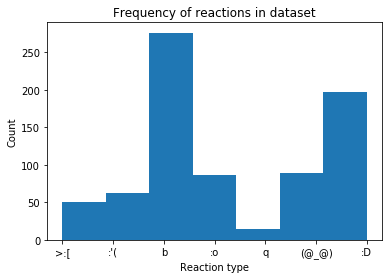

In [39]:
plt.hist(hist_friendly.values, bins=len(reacts))
plt.title("Frequency of reactions in dataset")
plt.xlabel("Reaction type")
plt.ylabel("Count")
plt.show()

We can also check who the top 10 reacters are.

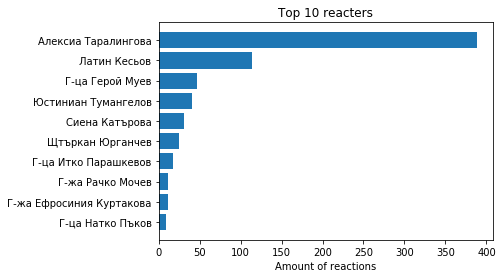

In [40]:
plt.barh(reactions.actor.value_counts()[9::-1].keys(), reactions.actor.value_counts()[9::-1].values)
plt.title("Top 10 reacters")
plt.xlabel("Amount of reactions")
plt.show()

Oops, of course my name will be on top of the list. After all, my reactions should be approximately equal to the sum of the rest of the reactions, assuming we have large enough data.

In [41]:
print(f"My reacts: {reactions[reactions.actor==ME].reaction.count()} ~ \
Rest of reacts: {reactions[reactions.actor!=ME].reaction.count()}")

My reacts: 389 ~ Rest of reacts: 388


We can treat my name like an outlier and get rid of it for a more accurate representation of the data.

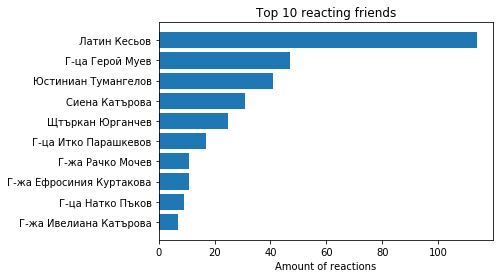

In [42]:
plt.barh(reactions.actor.value_counts()[10:0:-1].keys(), reactions.actor.value_counts()[10:0:-1].values)
plt.title("Top 10 reacting friends")
plt.xlabel("Amount of reactions")
plt.show()

But that's still not of much use to us. We want to find the best match, not the person who reacts to our messages the most. We can take a look at the sum of our reactions and our friends reactions in a conversation.

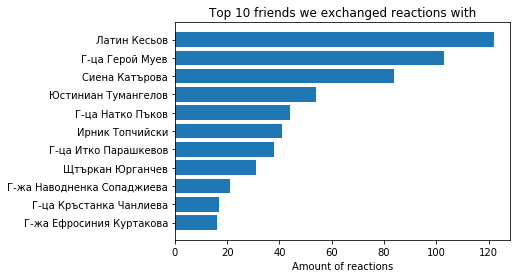

In [43]:
plt.barh(mess[mess.reactions.notna()].friend_name.value_counts()[10::-1].keys(), mess[mess.reactions.notna()].friend_name.value_counts()[10::-1].values)
plt.title("Top 10 friends we exchanged reactions with")
plt.xlabel("Amount of reactions")
plt.show()

So this is one option for matchaking. There's obviously some sort of emotional connection here between the topmost reactees and me. Or maybe not, let's continue exploring.

In [44]:
mess.drop(columns=['reactions'], inplace=True)

#### 5.2 Links

How about the `share` column? We saw a teaser of its content when we checked all the messages of type "Share". Let's have a closer look.

In [45]:
links = mess[mess.share.notnull()].share.apply(pd.Series)
links.head()

,link,share_text
timestamp,,
2010-07-16 10:09:14.000,http://gdata.youtube.com/feeds/api/videos/McTp...,NaN
2010-10-08 19:36:37.000,http://www.facebook.com/help/identify.php?show...,NaN
2010-12-05 22:32:28.000,http://gdata.youtube.com/feeds/api/videos/AmOi...,NaN
2011-03-16 19:17:24.000,http://subs.sab.bz/index.php?s=c8985318b46627e...,NaN
2011-11-11 11:54:08.555,http://www.zamunda.net/details.php?id=286556&h...,NaN


As we suspected, it contains a link and some column `share_text`.

In [46]:
links[links.share_text.notna()]

,link,share_text
timestamp,,
2018-07-23 10:32:20.082,NaN,Last update Jul 23
2018-09-02 14:12:18.566,NaN,Last update Sep 2
2018-11-04 02:41:57.917,https://www.facebook.com/TryNotToCryDM/posts/2...,Daily Mail
2019-05-28 18:02:06.854,NaN,Last update May 28


Yeah, we don't need the `share_text` column, but how about the links themselves?

If facebook extracts all the links from the messages correctly, then that can come in handy when we're processing the `content`.
We can check if that is the case by applying our own regex counter on the content and see if there are any links that facebook missed.

Before we take facebook's parsing skills to the test, let's do a qick test of ours. We will assume that the links that facebook already parsed are 100% valid.

In [47]:
test_count_by_us = links.link.str.count(r'https?:\/\/\S*').sum()
test_count_by_fb = links.link.dropna().count()

precision = test_count_by_us / test_count_by_fb

print(f"Our precision is {precision*100} %")

Our precision is 100.0 %


Great, it matches all the parsed links but does it work with the `content` column?

In [48]:
our_links_in_content = mess.content[mess.type=='Share'].str.extractall(r'(https?:\/\/\S*)')[0]
fb_links_in_shared = links.link.dropna()

In [49]:
our_links_in_content.isin(fb_links_in_shared).value_counts()

False    3862
True      919
Name: 0, dtype: int64

Oops, is our regex broken? Or is there a difference in the way facebook stores the links in the `share` column with the raw links in `content`. Let's try a different approach.

In [50]:
our_simplified_links_in_content = our_links_in_content.apply(lambda x: urlparse(x).netloc)
our_simplified_links_in_content.value_counts().head(7)

www.youtube.com     2331
www.facebook.com     834
youtu.be              93
www.reddit.com        79
i.imgur.com           72
drive.google.com      63
soundcloud.com        42
Name: 0, dtype: int64

In [51]:
fb_simplified_links_in_shared = fb_links_in_shared.apply(lambda x: urlparse(x).netloc)
fb_simplified_links_in_shared.value_counts().head(7)

www.youtube.com     2445
www.facebook.com     874
www.reddit.com        83
i.imgur.com           64
drive.google.com      58
soundcloud.com        42
xkcd.com              38
Name: link, dtype: int64

Ah, in our top links we have both "<span>www</span>.youtube.com" and "youtu.be", while facebook detects it's the same website and combines them both.

In [52]:
our_simplified_links_in_content.count()

4781

In [53]:
fb_simplified_links_in_shared.count()

4880

Nevertheless we can detect most of the links and that's enough to check if there are any in the messages of type "Generic".

In [54]:
links_in_generic = mess.content[mess.type=='Generic'].str.extractall(r'(https?:\/\/\S*)')
print("Links that Facebook missed:", int(links_in_generic.count()))

Links that Facebook missed: 6263


Yes, indeed, we can not trust facebook's parsing of links as there is a staggering amount of them in the "Generic" type messages.

Looks like facebook sent us on a wild goose chase with this `share` column as it's better to just parse the links of the messages ourselves. 

In [55]:
mess.drop(columns=['type', 'share'], inplace=True)
mess.content.dropna(inplace=True)

Since we already have all the links, let's do something fun with them.

In [56]:
combined_links = pd.concat([links_in_generic, our_links_in_content], levels=0)[0]

all_links = combined_links.apply(lambda x: urlparse(x).netloc)
all_links = all_links.sort_index()

all_protocols = combined_links.apply(lambda x: urlparse(x).scheme)
all_protocols = all_protocols.sort_index()

top_level_domains = combined_links.apply(lambda x: urlparse(x).netloc.split('.')[-1].split(':')[0])

Can you guess my nationality?

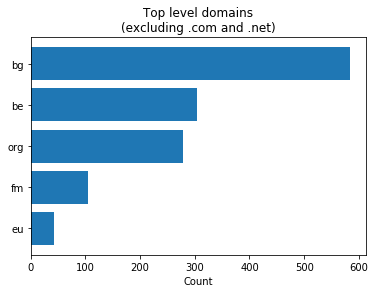

In [57]:
top_tld = top_level_domains[~top_level_domains.isin(['com', 'net'])].value_counts().nlargest(5)
plt.barh(top_tld.keys()[::-1], top_tld.values[::-1])
plt.title('Top level domains\n(excluding .com and .net)')
plt.xlabel('Count')
plt.show()

How much time does it take to secure the internet?

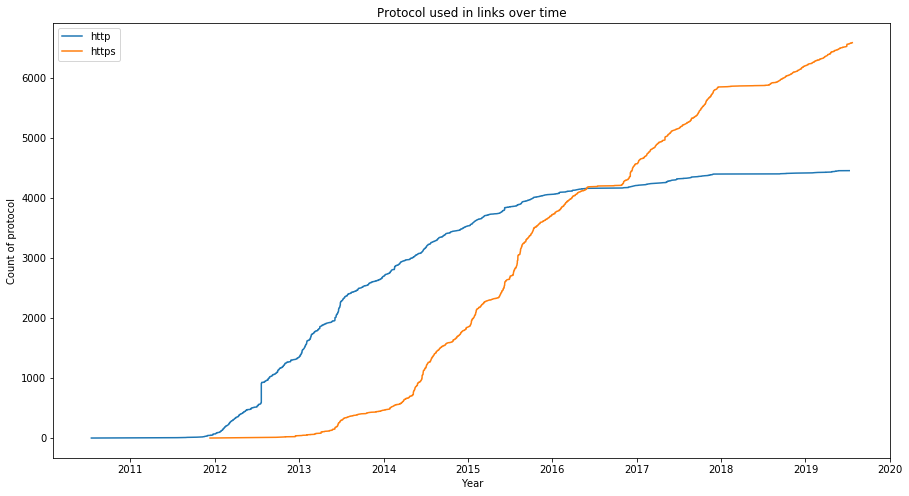

In [58]:
plt.figure(figsize=(15, 8))

for value in ['http', 'https']:
    line = all_protocols[all_protocols.values==value].reset_index()
    plt.plot(line.timestamp, line.index)

plt.title('Protocol used in links over time')
plt.xlabel('Year')
plt.ylabel('Count of protocol')   
plt.legend(['http', 'https'])
plt.show()

Can you pinpoint the moment I started coding?

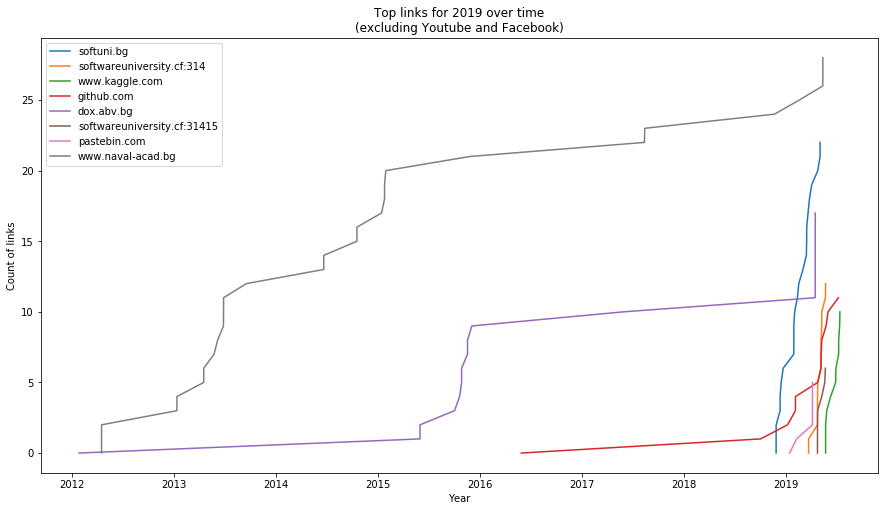

In [59]:
plt.figure(figsize=(15, 8))
                                # Year
top_links_list = list(all_links[(all_links.index.get_level_values(0).year==2019) &
                                # Excluding
                                (~all_links.isin(['www.youtube.com', 'www.facebook.com', 'youtu.be']))]\
                                # Top n  
                                .value_counts().nlargest(8).keys())

top_links = all_links[all_links.isin(top_links_list)]
for value in top_links_list:
    line = top_links[top_links.values==value].reset_index()
    plt.plot(line.timestamp, line.index)
    
plt.title('Top links for 2019 over time\n(excluding Youtube and Facebook)')
plt.xlabel('Year')
plt.ylabel('Count of links')
plt.legend(top_links_list)
plt.show()

### 6 Word processing

Now we are at the meat of the matter. Each message consists of multiple words. We want to process the words, not the whole message. But if we apply a split we get a list for each row in the dataset and iterating over list objects is extremely inefficient way of doing any kind of word processing. To solve this problem, we will split all the words into separate rows.

Before we do that, however, we need to get the top senders, because it will take too much time to split the words into rows if we take into acount all the friends. And besides, the top message sending people in our dataset are most likely our best friends or just people we click with, thus making them the best candidates for a match.

#### 6.1 Best friends
The count of messages is not representative for the amount a person texts, because some people write longer messages than others. For this reason we will count the words in each message as a measure of text written.

In [60]:
# Just a rough estimate
count_of_words = mess.content.str.count(r"\w+")
mess['wordcount_regex'] = count_of_words

But should we group by amount of text exchanged between me and them or by the top senders?

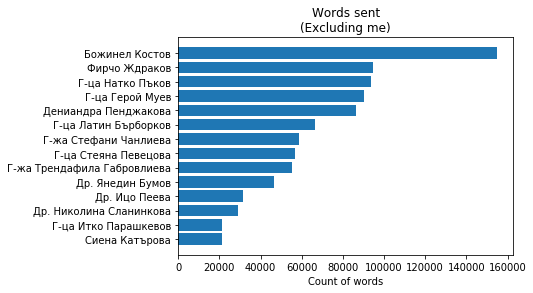

In [61]:
grouped_by_sender = mess.groupby(mess.sender_name).wordcount_regex.sum()
plt.barh(grouped_by_sender.nlargest(15)[:0:-1].index, grouped_by_sender.nlargest(15)[:0:-1].values)
plt.title("Words sent\n(Excluding me)")
plt.xlabel("Count of words")
plt.show()

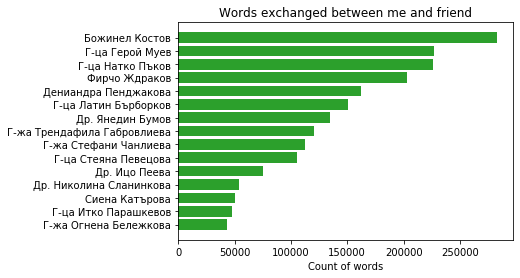

In [62]:
grouped_by_friend = mess.groupby(mess.friend_name).wordcount_regex.sum()
plt.barh(grouped_by_friend.nlargest(15)[::-1].index, grouped_by_friend.nlargest(15)[::-1].values, color="C2")
plt.title("Words exchanged between me and friend")
plt.xlabel("Count of words")
plt.show()

There are some differences in the position each person is, but the people are more or less the same.
This gives us an idea to check the differences between the amount of texting I have done and that of my friends.

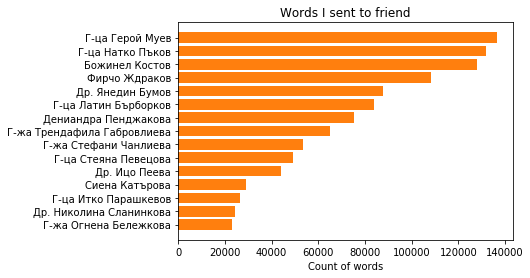

In [63]:
grouped_by_me = grouped_by_friend.nlargest(15) - grouped_by_sender.nlargest(16)
grouped_by_me = grouped_by_me.dropna()

plt.barh(grouped_by_me.nlargest(15)[::-1].index, grouped_by_me.nlargest(15)[::-1].values, color="C1")

plt.title("Words I sent to friend")
plt.xlabel("Count of words")
plt.show()

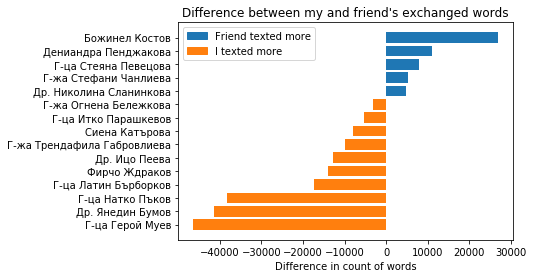

In [64]:
grouped_by_diff = grouped_by_sender.nlargest(16) - grouped_by_me.nlargest(15)


plt.barh(grouped_by_diff.nlargest(15)[::-1].index, grouped_by_diff.nlargest(15)[::-1].values,
         color=["C1" if i < 0 else "C0" for i in grouped_by_diff.nlargest(15)[::-1].values])

plt.title("Difference between my and friend's exchanged words")
plt.xlabel("Difference in count of words")
blue_patch = mpatches.Patch(color='C0', label='Friend texted more')
orange_patch = mpatches.Patch(color='C1', label='I texted more')
plt.legend(handles=[blue_patch, orange_patch])
plt.show()

Interesting. It looks like I text more than my friends. As a side note we can hypothesize that our best match could be somewhere in the middle of the graph, where we both texted the same amount.

We chose the top 15 people because it looks good on a graph. But are the top 15 friends the optimal amount of people we should take as "best friends" or should we take the top 30, top 50? Let's see.

In [65]:
# This time we split by space
space_mess = mess.copy()
space_mess.content = space_mess.content.str.split()
space_mess.content.dropna(inplace=True)

In [66]:
space_mess['wordcount_space'] = space_mess.content.apply(len)

In [67]:
space_mess.tail()

,sender_name,content,friend_name,wordcount_regex,wordcount_space
timestamp,,,,,
2019-07-22 15:08:48.294,Ирник Топчийски,"[ако, мн, го, закъсаш, с, събирането, на, съоб...",Ирник Топчийски,14,14
2019-07-22 15:09:15.928,Алексиа Таралингова,"[добре,, чакай, сега, недей, да, пишеш, за, из...",Ирник Топчийски,10,10
2019-07-22 15:09:31.911,Алексиа Таралингова,"[some, english, text, 123, wohoo, yeaaah, !!!,...",Ирник Топчийски,7,8
2019-07-22 15:09:55.550,Алексиа Таралингова,"[sh1okavica, bum, bam, nqkvi, dumi]",Ирник Топчийски,5,5
2019-07-22 15:10:12.635,Алексиа Таралингова,"[данчо, е, супер, пич, 😎]",Ирник Топчийски,4,5


In [68]:
best_friends = space_mess.groupby('sender_name').wordcount_space.sum().nlargest(len(list(space_mess.sender_name.unique())))
best_friends.head()

sender_name
Алексиа Таралингова     1706574
Божинел Костов           154367
Г-ца Натко Пъков          94046
Фирчо Ждраков             93152
Дениандра Пенджакова      85045
Name: wordcount_space, dtype: int64

In [69]:
best_friends[1:].describe()

count       588.000000
mean       2434.185374
std       11200.352195
min           1.000000
25%          27.750000
50%         149.000000
75%         776.750000
max      154367.000000
Name: wordcount_space, dtype: float64

We can see that the top 28 people are responsible for 25% of all the text in my messages(myself not included).

In [70]:
best_friends[1:].skew()

8.47288658126157

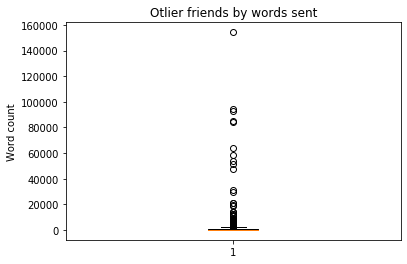

In [71]:
plt.boxplot(best_friends[1:])
plt.title("Otlier friends by words sent")
plt.ylabel("Word count")
plt.show()

The majority of people have such a small word count that we can't even see the interquartile range of the boxplot. But if we look at the outliers we can see that there are just a few above 20000 words. How many exactly? About 15. If we had more time and recources on our hands we could try with a bigger number, but for now this is the one we're sticking with.

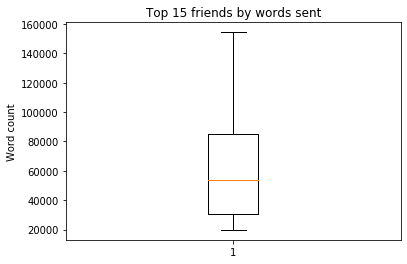

In [72]:
n=15

plt.boxplot(best_friends[1:n+1])
plt.title(f"Top {n} friends by words sent")
plt.ylabel("Word count")
plt.show()

How about our messages? We've taken all of them but maybe it's too much?

In [73]:
print(f"My words: {best_friends.max():.0f}")
print(f"Sum of my friends words: {best_friends[1:].nlargest(n).sum():.0f}")
print(f"Currently the sum of our top {n} friend words makes up {best_friends[1:].nlargest(n).sum() / best_friends.max() * 100:.2f} % of our own words.")

My words: 1706574
Sum of my friends words: 908694
Currently the sum of our top 15 friend words makes up 53.25 % of our own words.


The most logical solution is to only take the messages we've exchanged with these top 15 friends.

In [74]:
best_space_mess = space_mess[space_mess.friend_name.isin(list(best_friends[1:n+1].index))]

In [75]:
print(f"The sum of our top {n} friend words makes up {best_friends[1:].nlargest(n).sum() / best_space_mess[best_space_mess.sender_name==ME].wordcount_space.sum() * 100:.2f} % of our own words.")

The sum of our top 15 friend words makes up 90.14 % of our own words.


#### 6.2 Emojicons
And now we must discuss the emoji-problem. First of all, there is a difference between emoticons and emojis. Emoticons are punctuation marks, letters, and numbers used to create pictorial icons that generally display an emotion or sentiment. Not to be confused with their predecessor, emojis are pictographs of faces, objects, and symbols.

Emoticons: `>:( ;( :o (@_@) :D <3`

Emojis: `😠 😢 😮 😍 😆 ❤`

From now on, when I'm referring to them both, I will use the term "emojicons".

The reason we split by space was to preserve the emojicons in our messages. Why not discard them, I hear you ask. Are emojicons words? Well they "generally display an emotion or sentiment" and a text can have entirely different meaning depending on the emojicon. Some examples:

What are you doing? :) --> We're friends and I'm just chatting up.

What are you doing? >:( --> You've done something that upsets me and I'm mad at you.

What are you doing? ;) --> I want to have sex with you.

What are you doing? :o --> I can't believe you just did that.


The downside of this space split is that all the punctuatuion is now messing up our words. We can do tokenization on each string that is not an emojicon but then again we get lists inside our rows. That is why we will operate on two different copies of the same dataset - one split by space, and one using nltk's tokenization module.

In [76]:
best_tokenized_mess = mess.copy()
best_tokenized_mess = best_tokenized_mess[best_tokenized_mess.friend_name.isin(list(best_friends[1:n+1].index))]
# We already have the links in a separate dataframe
best_tokenized_mess.content = best_tokenized_mess.content.str.replace(r'https?:\/\/\S*', '')
best_tokenized_mess.content = best_tokenized_mess.content.apply(word_tokenize)
best_tokenized_mess.content.dropna(inplace=True)

In [77]:
best_space_mess.reset_index(inplace=True)
best_tokenized_mess.reset_index(inplace=True)

In [78]:
best_tokenized_mess.tail()

,timestamp,sender_name,content,friend_name,wordcount_regex
422845,2019-07-22 09:10:12.705,Г-ца Итко Парашкевов,"[how, even]",Г-ца Итко Парашкевов,2
422846,2019-07-22 12:32:07.163,Алексиа Таралингова,[хахахахха],Фирчо Ждраков,8
422847,2019-07-22 13:12:25.649,Фирчо Ждраков,"[тъкмо, го, видях, ама, не, мога, да, го, глед...",Фирчо Ждраков,13
422848,2019-07-22 13:12:37.012,Алексиа Таралингова,"[много, ме, изкефи]",Фирчо Ждраков,3
422849,2019-07-22 13:12:45.281,Алексиа Таралингова,"[+, се, влюбих, в, мацката, :, d]",Фирчо Ждраков,5


Looks good. We can now start splicing and dicing.

In [79]:
def word_split(dataframe):
    rows = list()
    for row in dataframe[['sender_name', 'content', 'timestamp']].iterrows():
        r = row[1]
        for word in r.content:
            rows.append((r.sender_name, word, r.timestamp))

    return pd.DataFrame(rows, columns=['sender_name', 'word', 'timestamp'])

In [80]:
words_by_space = word_split(best_space_mess)
words_by_tokenizer = word_split(best_tokenized_mess)

# A signal to notify us when it's ready
Audio(np.sin(np.pi*np.arange(31415)), rate=9001, autoplay=True)

While we wait for all the words to be complete let's take a look at this handy flowchart.

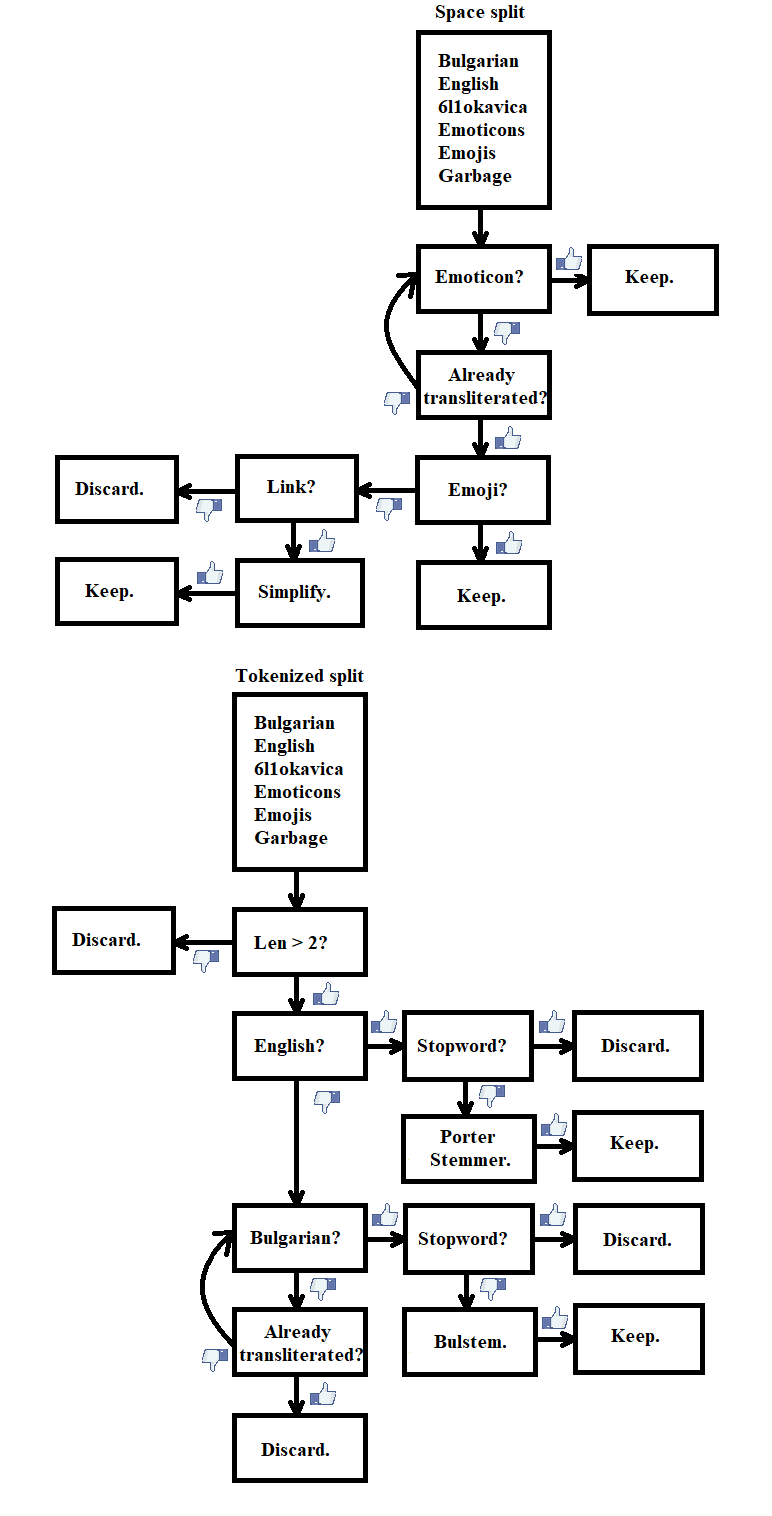

A quick glance over the results from the split.

In [81]:
words_by_space.word.value_counts().head(20)

да    54869
:d    47456
и     44710
е     36006
не    34804
се    25038
си    24737
на    22778
ми    19963
ще    17604
:д    17227
ти    16375
i     15996
за    14225
в     12988
от    12599
с     12573
че    12310
аз    11740
го    11417
Name: word, dtype: int64

In [82]:
words_by_tokenizer.word.value_counts().head(20)

:      70950
да     57066
d      51082
и      45074
,      43378
е      37956
не     36798
?      26120
си     25635
се     25464
на     22873
.      21233
ми     20809
д      20801
i      19326
ще     17706
ти     16911
...    15052
за     14344
в      13038
Name: word, dtype: int64

#### 6.3 Wordlists, emoticonilists and stop words

To see if a string is a valid emoticon, we will check if it's contained in the "emoticons.csv" dataset. The dataset is made up of 2242 emoticon and their count, taken from 96,269,892 Tweets. I could not find the original dataset so I made this one myself by copying the content of [this page](http://datagenetics.com/blog/october52012/index.html).

In [83]:
emoticons = pd.read_csv('emoticons.csv', sep='\t', header=None, names=['duplicate_index', 'emoticon', 'frequency']).drop(columns='duplicate_index')
emoticons.emoticon = emoticons.emoticon.str.lower()

In [84]:
emoticons.head(10)

,emoticon,frequency
0,:),"32,115,789"
1,:d,"10,595,385"
2,:(,"7,613,014"
3,;),"7,238,295"
4,:-),"4,254,708"
5,:p,"3,588,863"
6,=),"3,564,080"
7,(:,"2,720,383"
8,;-),"2,085,015"
9,:/,"1,840,827"


In [85]:
emoticons.tail(10)

,emoticon,frequency
2232,___^-^,1
2233,^_^bbb,1
2234,^_^v!!,1
2235,^_^)::,1
2236,^-^==,1
2237,[^_^*],1
2238,[^_^]//,1
2239,^-^.:,1
2240,]o8,1
2241,^-^*!!,1


Not bad but there are some emoticons I'd like to add.

In [86]:
extra_emoticons = pd.DataFrame(data=["^^", "^__^", "^___^", "(*^.^*)", "ಠ_ಠ",  "¯\_(ツ)_/¯", "( ͡° ͜ʖ ͡°)"], columns=["emoticon"])

In [87]:
emoticons = pd.concat([emoticons, extra_emoticons], sort=False).reset_index(drop=True).fillna(1)

In [88]:
emoticons.tail(10)

,emoticon,frequency
2239,^-^.:,1
2240,]o8,1
2241,^-^*!!,1
2242,^^,1
2243,^__^,1
2244,^___^,1
2245,(*^.^*),1
2246,ಠ_ಠ,1
2247,¯\_(ツ)_/¯,1
2248,( ͡° ͜ʖ ͡°),1


In our messages however, we have some emoticons like ":Д" which is supposed to be ":D" but written in cyrillic. No such list of cyrillic emoticons exists so if we have no match in the latin emoticons we will transliterate the cyrillic to latin and check again in the same dataset. We will use the same technique for the tokenized words.

Let's test if this transliterate module is working correctly for Bulgarian written in latin.

In [89]:
text = """
6l1okavitsa
shishe s1s ushi na 6ose se su6i
4i4kovite cherwenotikveni4kovcheta
macki, djanti, devetnaiski
neprotivokonstituciosnovatelstvuvaite
yovano, yovanke, shto t1i praish sq
"""

print(transliterate.translit(text.lower(), language_code='bg'))


6л1окавица
шише с1с уши на 6осе се су6и
4и4ковите черwенотиквени4ковчета
маcки, дjанти, деветнаиски
непротивоконституcиоснователствуваите
йовано, йованке, што т1и праиш сq



There is a lot that can be improved, and that is exactly what we shall do.

In [90]:
BulgarianLanguagePack.mapping = ('abwvgdejziyklmnoprstufhc461q', 'абввгдежзийклмнопрстуфхцчшъя')
"""
my additions:
    "1": "ъ",
    "6": "ш",
    "4": "ч",
    "q": "я",
    "w": "в",
    "j": "ж",
    "c": "ц",
    
removed all the uppercase characters for improved performance
ABVWGDEZIYKLMNOPRSTUFHCQ:АБВВГДЕЗИЙКЛМНОПРСТУФХЦЯ    
"""


BulgarianLanguagePack.reversed_specific_mapping = ('ьъ', 'y1')


BulgarianLanguagePack.pre_processor_mapping = {
    'zh': 'ж',
    'ts': 'ц',
    'ch': 'ч',
    'sh': 'ш',
    'шt': 'щ', # fixed
    'yu': 'ю',
    'ya': 'я',
    
    # my additions:
    "6t": "щ",
    "1o": "ьо",    
    "1i": "ъй",
    "ai": "ай",
    # "йо" only after vowel
    # and beginning of word
    "yo": "йо",
    "bй": "бь",
    "vй": "вь",
    "wй": "вь",
    "gй": "гь",
    "dй": "дь",
    "jй": "жь",
    "жй": "жь",
    "zй": "зь",
    "kй": "кь",
    "lй": "ль",
    "mй": "мь",
    "nй": "нь",
    "pй": "пь",
    "rй": "рь",
    "sй": "сь",
    "tй": "ть",
    "fй": "фь",
    "cй": "ць",
    "чй": "чь",
    "шй": "шь",
    "щй": "щь"}
"""
    removed:
    'Zh': 'Ж',
    'Ts': 'Ц',
    'Ch': 'Ч',
    'Sh': 'Ш',
    'Шt': 'Щ', # fixed
    'Yu': 'Ю',
    'Ya': 'Я',
"""

# Instead of callng the language code each time
translit_bg = transliterate.get_translit_function('bg')

In [91]:
print(translit_bg(text))


шльокавица
шише със уши на шосе се суши
чичковите червенотиквеничковчета
мацки, джанти, деветнайски
непротивоконституциоснователствувайте
йовано, йованке, що тъй прайш ся



In [92]:
translit_bg(text) == translit_bg(translit_bg(translit_bg(text), reversed=True))

True

Much better. Of course there's no doubt some words will be intransliterable, because people sometimes use the same latin letter for different cyrillic letters like "ujasno si tupa be jordanke", but that's the best we can do.

The next thing we have to check is if the string is a valid emoji. We can easily do that by checking if it's in python's emoji module like this:

In [93]:
pd.Series([">:(", ";(", ":o", "(@_@)", ":D", "<3"]).isin(UNICODE_EMOJI)

0    False
1    False
2    False
3    False
4    False
5    False
dtype: bool

In [94]:
pd.Series(["😠", "😢", "😮", "😍", "😆", "❤"]).isin(UNICODE_EMOJI)

0    True
1    True
2    True
3    True
4    True
5    True
dtype: bool

And that's pretty much it for our space splited messages. The tokenizer splitted messages follow the same logic as the emoticons, except we first check the length of the string and only pass through words containing more than 2 characters.

In [95]:
en_wordlist = pd.read_csv('en_words.csv', header=None, names=['word'])
en_wordlist.dtypes

word    object
dtype: object

In [96]:
en_wordlist.count()

word    370101
dtype: int64

In [97]:
en_wordlist.head()

,word
0,a
1,aa
2,aaa
3,aah
4,aahed


The Bulgarian wordlist is taken from a subtitles site and consists of words with frequencies.

In [98]:
bg_wordlist = pd.read_csv('bg_full.txt', header=None, delim_whitespace=True, names=['word', 'frequency'])

In [99]:
bg_wordlist.dtypes

word         object
frequency     int64
dtype: object

In [100]:
bg_wordlist.count()

word         1202469
frequency    1202471
dtype: int64

Okay, that's too much words. I'm guessing the less frequent ones are misspelled.

In [101]:
bg_wordlist.tail()

,word,frequency
1202466,заколяш,1
1202467,безопстно,1
1202468,педставлението,1
1202469,издалбала,1
1202470,коло-ните,1


Yes, indeed they are. We can take only words with frequencies greater than 2. Hopefully the people translating movies on the internet don't make the same mistakes more than twice.

In [102]:
bg_wordlist = bg_wordlist.dropna()
bg_wordlist = bg_wordlist[bg_wordlist.frequency > 2]

In [103]:
bg_wordlist.count()

word         454606
frequency    454606
dtype: int64

In [104]:
bg_wordlist.tail()

,word,frequency
454603,майдей,3
454604,20-чка,3
454605,аледа,3
454606,кетунен,3
454607,goldfish,3


Oops, there's obviously some english words here as well. Let's fix that too.

In [105]:
bg_wordlist = bg_wordlist[bg_wordlist.word.str.contains(pat=r'[a-zA-Z]+')==False].reset_index(drop=True)

In [106]:
bg_wordlist.tail(20)

,word,frequency
417478,мащабирате,3
417479,12-инчови,3
417480,хъдълстън,3
417481,междините,3
417482,китъри,3
417483,задиряне,3
417484,пермското,3
417485,дублеков,3
417486,реланиум,3
417487,съдърфорд,3


There are still some typos here and there but for our purposes I say that's okay.

Now all that's left to do is load the stopwords.

In [107]:
bg_stopwords = pd.read_csv('bulgarian.txt', header=None, names=['word']).word

In [108]:
bg_stopwords.tail(10)

249        ч
250     часа
251       че
252    често
253     чрез
254       ще
255      щом
256    юмрук
257        я
258       як
Name: word, dtype: object

In [109]:
en_stopwords = pd.Series(stopwords.words('english'))

In [110]:
en_stopwords.tail(10)

169      shouldn
170    shouldn't
171         wasn
172       wasn't
173        weren
174      weren't
175          won
176        won't
177       wouldn
178     wouldn't
dtype: object

#### 6.4 Extracting valid words

A quick optimization beforehand:

In [111]:
words_by_space.memory_usage()

Index                80
sender_name    15334120
word           15334120
timestamp      15334120
dtype: int64

In [112]:
words_by_space.sender_name = words_by_space.sender_name.astype('category')
words_by_space.word = words_by_space.word.astype('category')

words_by_tokenizer.sender_name = words_by_tokenizer.sender_name.astype('category')
words_by_tokenizer.word = words_by_tokenizer.word.astype('category')

words_by_space.memory_usage()

Index                80
sender_name     1917533
word           14143060
timestamp      15334120
dtype: int64

In [113]:
words_by_space.dtypes

sender_name          category
word                 category
timestamp      datetime64[ns]
dtype: object

And we just follow the flowchart.

<br>

Check to see if it is a latin emoticon.

In [114]:
emoticons_latin = words_by_space[(words_by_space.word.isin(emoticons.emoticon))]

In [115]:
emoticons_latin.word.value_counts().head(15)

:d     47456
;d      2649
:)       677
<3       426
;)       323
^^       321
xd       280
=d       278
:(       267
:/       256
:p       232
d:       131
^_^      128
:-d      100
;(        57
Name: word, dtype: int64

Check to see if it's a cyrillic emoticon.

In [116]:
emoticons_recycled = words_by_space[(words_by_space.word.isin(emoticons.emoticon))==False].copy()
emoticons_recycled.word = emoticons_recycled.word.apply(translit_bg, args=(reversed, True))
emoticons_recycled = emoticons_recycled[emoticons_recycled.word.isin(emoticons.emoticon)]

In [117]:
emoticons_recycled.word.value_counts().head(15)

:d     17227
;d      2315
d:       127
:p        91
;p        25
d;        23
:o        11
do:        2
p:         2
=d         2
o:         1
Name: word, dtype: int64

Revert back to cyrillic state to preserve semantic meaning.

In [118]:
emoticons_recycled.word = emoticons_recycled.word.apply(translit_bg)

In [119]:
emoticons_recycled.word.value_counts()

:д     17227
;д      2315
д:       127
:п        91
;п        25
д;        23
:о        11
до:        2
=д         2
п:         2
о:         1
Name: word, dtype: int64

Visualize data.

In [120]:
emoticons_combined = pd.concat(objs=[emoticons_latin, emoticons_recycled])

In [121]:
emoticons_combined.word = emoticons_combined.word.str.upper()

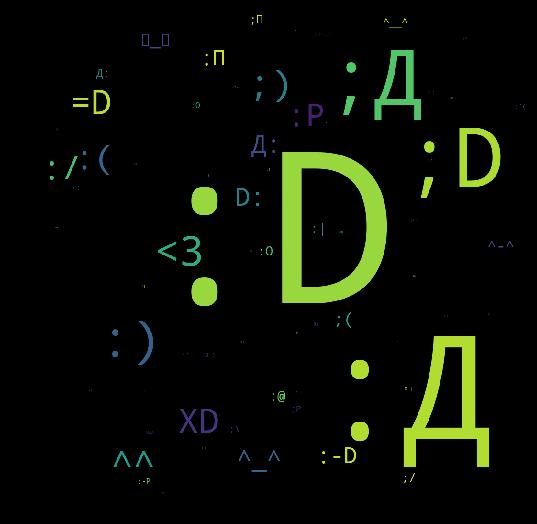

In [122]:
reacts = WordCloud(width=1024, height = 1024, prefer_horizontal=1).generate_from_frequencies(emoticons_combined.word.str.upper().value_counts())
plt.figure(figsize=(12, 9), facecolor='k')
plt.imshow(reacts)
plt.show()

Check if it's a valid emoji.

In [123]:
emojis = words_by_space[words_by_space.word.isin(UNICODE_EMOJI)]

In [124]:
emojis.word.value_counts().head(15)

😃    3365
😀     885
😂     148
😁     101
😘      50
😄      41
😉      30
😎      29
🙂      18
☺      16
😝      15
😞      13
😏      10
✌      10
😮      10
Name: word, dtype: int64

Combine all emojicons.

In [125]:
emojicons = pd.concat(objs=[emoticons_combined, emojis])

In [126]:
emojicons.word.value_counts()

:D     47456
:Д     17227
😃       3365
;D      2649
;Д      2315
😀        885
:)       677
<3       426
;)       323
^^       321
XD       280
=D       278
:(       267
:/       256
:P       232
😂        148
D:       131
^_^      128
Д:       127
😁        101
:-D      100
:П        91
;(        57
ಠ_ಠ       53
😘         50
^-^       42
😄         41
:@        37
:|        34
:O        31
       ...  
🍭          1
):         1
😛          1
:{         1
🐙          1
😩          1
🚼          1
⚽          1
🎅🏿         1
;@         1
👓          1
🌟          1
👟          1
🥊          1
🔨          1
🙆🏼         1
P=         1
:-(        1
🍆          1
☢          1
🙀          1
🙆🏻         1
;O         1
👺          1
😰          1
🙋🏻         1
😬          1
:}         1
⚡          1
😐          1
Name: word, Length: 218, dtype: int64

Check if string is in already parsed links.

In [127]:
websites = words_by_space[words_by_space.word.isin(combined_links)].copy()
websites.word = websites.word.apply(lambda x: urlparse(x).netloc)

In [128]:
websites.word.value_counts().head()

www.youtube.com     3058
www.facebook.com    1006
get.adobe.com        320
youtu.be             171
i.imgur.com          149
Name: word, dtype: int64

What the hell? The "get.adobe.com" link wasn't in the top positions before. Let us investigate.

In [129]:
websites[websites.word.isin(["get.adobe.com"])].head(10)

,sender_name,word,timestamp
35613,Алексиа Таралингова,get.adobe.com,2012-07-20 21:40:08.338
35636,Алексиа Таралингова,get.adobe.com,2012-07-20 21:41:30.156
35643,Алексиа Таралингова,get.adobe.com,2012-07-20 21:42:00.780
35644,Алексиа Таралингова,get.adobe.com,2012-07-20 21:42:00.780
35645,Алексиа Таралингова,get.adobe.com,2012-07-20 21:42:00.780
35646,Алексиа Таралингова,get.adobe.com,2012-07-20 21:42:00.780
35647,Алексиа Таралингова,get.adobe.com,2012-07-20 21:42:00.780
35648,Алексиа Таралингова,get.adobe.com,2012-07-20 21:42:00.780
35649,Алексиа Таралингова,get.adobe.com,2012-07-20 21:42:00.780
35650,Алексиа Таралингова,get.adobe.com,2012-07-20 21:42:00.780


In [130]:
mess[mess.index=="2012-07-20 21:42:00.780"].content.tolist()

['http://get.adobe.com/flashplayer/ http://get.adobe.com/flashplayer/ http://get.adobe.com/flashplayer/ http://get.adobe.com/flashplayer/ http://get.adobe.com/flashplayer/ http://get.adobe.com/flashplayer/ http://get.adobe.com/flashplayer/ http://get.adobe.com/flashplayer/ http://get.adobe.com/flashplayer/ http://get.adobe.com/flashplayer/ http://get.adobe.com/flashplayer/ http://get.adobe.com/flashplayer/ http://get.adobe.com/flashplayer/ http://get.adobe.com/flashplayer/ http://get.adobe.com/flashplayer/ http://get.adobe.com/flashplayer/ http://get.adobe.com/flashplayer/ http://get.adobe.com/flashplayer/ http://get.adobe.com/flashplayer/ http://get.adobe.com/flashplayer/ http://get.adobe.com/flashplayer/ http://get.adobe.com/flashplayer/ http://get.adobe.com/flashplayer/ http://get.adobe.com/flashplayer/ http://get.adobe.com/flashplayer/ http://get.adobe.com/flashplayer/ http://get.adobe.com/flashplayer/ http://get.adobe.com/flashplayer/ http://get.adobe.com/flashplayer/ http://get.a

I'm classifying this as garbage and moving on.

In [131]:
websites = websites[websites.word.isin(["get.adobe.com"])==False]

In [132]:
websites.word.value_counts().head()

www.youtube.com     3058
www.facebook.com    1006
youtu.be             171
i.imgur.com          149
www.reddit.com       114
Name: word, dtype: int64

Next are all the tokenized words. First we discard all words with length smaller than 3 characters.

In [133]:
words_by_tokenizer = words_by_tokenizer[words_by_tokenizer.word.apply(len) >= 3]

Then we check each word in the English and Bulgarian wordlist.

In [134]:
bg_words = words_by_tokenizer[(words_by_tokenizer.word.isin(bg_wordlist.word))
                              & (words_by_tokenizer.word.isin(en_wordlist.word)==False)]

en_words = words_by_tokenizer[(words_by_tokenizer.word.isin(en_wordlist.word)) 
                              & (words_by_tokenizer.word.isin(bg_wordlist.word)==False)]

recycled_words = words_by_tokenizer[(words_by_tokenizer.word.isin(bg_wordlist.word)==False) 
                                    & (words_by_tokenizer.word.isin(en_wordlist.word)==False)]

A quick function for easier view of the three categories.

In [135]:
def top_words_each(df1, df2, df3, n=10):
    top_words_each = pd.DataFrame(data=[df1.word.value_counts().head(n).index, df2.word.value_counts().head(n).index, df3.word.value_counts().head(n).index]).T
    top_words_each.columns = ['bg', 'en', 'rec']
    return top_words_each

In [136]:
top_words_each(bg_words, en_words, recycled_words)

,bg,en,rec
0,ама,you,...
1,съм,the,n't
2,като,and,idk
3,ако,that,'re
4,няма,like,lol
5,може,what,shte
6,има,not,'ll
7,това,but,ддз
8,как,just,btw
9,само,well,смис


In [137]:
recycled_words = recycled_words.copy()
recycled_words.word = recycled_words.word.apply(translit_bg)
recycled_words = recycled_words[recycled_words.word.isin(bg_wordlist.word)]

In [138]:
top_words_each(bg_words, en_words, recycled_words)

,bg,en,rec
0,ама,you,идк
1,съм,the,лол
2,като,and,ще
3,ако,that,бтв
4,няма,like,като
5,може,what,няма
6,има,not,как
7,това,but,само
8,как,just,тва
9,само,well,нах


Check if it's a stopword.

In [139]:
bg_words = bg_words[bg_words.word.isin(bg_stopwords)==False]
en_words = en_words[en_words.word.isin(en_stopwords)==False]
recycled_words = recycled_words[recycled_words.word.isin(bg_stopwords)==False]

In [140]:
top_words_each(bg_words, en_words, recycled_words)

,bg,en,rec
0,ама,like,идк
1,тва,well,лол
2,кво,know,бтв
3,знам,yeah,тва
4,просто,one,нах
5,еми,get,мех
6,нали,good,нали
7,имам,fuck,кинда
8,дае,time,ама
9,щот,okay,еми


Stemming.

In [141]:
# I've changed a few lines of code in bulstem.py to make it work with python 3
bg_words.word = bg_words.word.apply(stem)
en_words.word = en_words.word.apply(PorterStemmer().stem)
recycled_words.word = recycled_words.word.apply(stem)

In [142]:
top_words_each(bg_words, en_words, recycled_words)

,bg,en,rec
0,ама,like,идк
1,иска,well,лол
2,тва,know,иска
3,кво,yeah,бтв
4,знам,fuck,тва
5,прав,one,нах
6,просто,get,мех
7,имам,time,нали
8,някв,want,кинд
9,мисл,good,ама


Return Bulgarian words in original latin state.

In [143]:
recycled_words.word = recycled_words.word.apply(translit_bg, args=(reversed, True))

In [144]:
top_words_each(bg_words, en_words, recycled_words)

,bg,en,rec
0,ама,like,idk
1,иска,well,lol
2,тва,know,iska
3,кво,yeah,btv
4,знам,fuck,tva
5,прав,one,nah
6,просто,get,meh
7,имам,time,nali
8,някв,want,kind
9,мисл,good,ama


Combine all processed strings.

In [145]:
processed_words = pd.concat(objs=[bg_words, en_words, recycled_words, websites, emojicons])

In [146]:
processed_words.word.value_counts().head(10)

:D        47456
:Д        17227
ама       10371
иска       4881
тва        4551
кво        4098
знам       3526
прав       3507
просто     3439
😃          3365
Name: word, dtype: int64

And now we must make a corpus out of all the separate words.

If we bring them back to their original state there are too many messages consisting of only a single word, so that is why we must merge a few messages to make a bigger text.
We can experiment with different time periods by which to group the words, but the configuration I've decided on is to join all the words written in a single hour(by each sender).

In [147]:
processed_mess = processed_words.groupby(["sender_name", processed_words.timestamp.dt.year, processed_words.timestamp.dt.month, processed_words.timestamp.dt.day, processed_words.timestamp.dt.hour]).word.agg(lambda x: ' '.join(x))

In [148]:
# processed_words['rapid_fire'] = processed_words[processed_words.timestamp.diff() <= '0 days 00:00:03.333'

In [149]:
processed_mess = pd.DataFrame(processed_mess)

In [150]:
processed_mess.tail()

word
sender_name   timestamp timestamp timestamp timestamp                                                   
Фирчо Ждраков 2019      7         14        20         иска чете ясно спя рано став айде taka momenta...
                                  18        16                                        бяхм училищ казв 😃
                                            17         пита адриян мда дайт хаха свет нощт връща изгу...
                                  21        13                        накъде ходи ади трит лъва еее жалк
                                  22        13                                 тъкм видя ама гледам рабо

In [151]:
processed_mess = processed_mess.reset_index(level=0).set_index('sender_name')
processed_mess.columns = ['content']

In [152]:
processed_mess.tail()

,content
sender_name,
Фирчо Ждраков,иска чете ясно спя рано став айде taka momenta...
Фирчо Ждраков,бяхм училищ казв 😃
Фирчо Ждраков,пита адриян мда дайт хаха свет нощт връща изгу...
Фирчо Ждраков,накъде ходи ади трит лъва еее жалк
Фирчо Ждраков,тъкм видя ама гледам рабо


### 7 Modelling

We are going to use Scikit's Multinomial Naive Bayes classifier because it is easiest to implement and it's faster than the rest.

First we will test how it's doing without my messages because we want to see how accurate the classifier is in general.

In [153]:
test_data_others = processed_mess[(processed_mess.index != ME)]
train_x, test_x, train_y, test_y = model_selection.train_test_split(test_data_others.content, test_data_others.index, test_size=0.30)

In [154]:
tf_idf_vectorizor = TfidfVectorizer()
tf_idf = tf_idf_vectorizor.fit_transform(test_data_others.content)
tf_idf_norm = normalize(tf_idf)
train_x_tfidf = tf_idf_vectorizor.transform(train_x)
test_x_tfidf = tf_idf_vectorizor.transform(test_x)

In [155]:
mnb = MultinomialNB()
mnb.fit(train_x_tfidf, train_y)
mnb_prediction = mnb.predict(test_x_tfidf)

In [156]:
mnb.score(test_x_tfidf, test_y)

0.48773448773448774

In [157]:
print(classification_report(test_y, mnb_prediction, labels=np.unique(mnb_prediction)))

                             precision    recall  f1-score   support

             Божинел Костов       0.67      0.57      0.62       323
      Г-жа Стефани Чанлиева       0.98      0.45      0.62       108
Г-жа Трендафила Габровлиева       0.83      0.07      0.13       142
            Г-ца Герой Муев       0.55      0.84      0.67       425
       Г-ца Латин Бърборков       1.00      0.03      0.06       152
           Г-ца Натко Пъков       0.39      0.90      0.55       523
       Дениандра Пенджакова       0.97      0.18      0.30       179
              Др. Ицо Пеева       0.89      0.07      0.14       218
    Др. Николина Сланинкова       1.00      0.02      0.04       133
           Др. Янедин Бумов       0.70      0.60      0.64       366
             Сиена Катърова       0.92      0.06      0.11       186
              Фирчо Ждраков       0.37      0.76      0.50       441

                  micro avg       0.49      0.53      0.51      3196
                  macro avg     

As we can see, our classifier is not great. Maybe we did something wrong, or maybe my best friends are so similar that they can't be distinguished. We will see who is our best match nevertheless.

In [158]:
# All the data for more accurate results
train_x, train_y = test_data_others.content, test_data_others.index

In [159]:
train_x_tfidf = tf_idf_vectorizor.transform(train_x)

In [160]:
# Training model
my_mnb = MultinomialNB()
my_mnb.fit(train_x_tfidf, train_y)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [161]:
me_data = processed_mess[processed_mess.index == ME]
me_test_x_tfidf = tf_idf_vectorizor.transform(me_data.content)
my_prediction = my_mnb.predict(me_test_x_tfidf)

In [162]:
print("Match percentages:\n")
for pair in sorted(Counter(my_prediction).items(), key=lambda x: -x[1]):
    print(f"{pair[0]} -> {(pair[1]/len(me_data.index)*100):.2f} %")

Match percentages:

Г-ца Натко Пъков -> 38.52 %
Фирчо Ждраков -> 22.68 %
Г-ца Герой Муев -> 21.55 %
Др. Янедин Бумов -> 9.72 %
Божинел Костов -> 7.02 %
Др. Ицо Пеева -> 0.23 %
Дениандра Пенджакова -> 0.08 %
Сиена Катърова -> 0.07 %
Г-жа Трендафила Габровлиева -> 0.06 %
Г-ца Латин Бърборков -> 0.05 %
Др. Николина Сланинкова -> 0.02 %
Г-ца Стеяна Певецова -> 0.01 %


### Conclusion

In my opinion the match-maker works. But to match with a person can have all sorts of different interpretations and for some people the things we explored might not be the best measure. As for usability, this notebook is only an example how chat messages between bilingual people can be processed. A universal analyzer can't take into account the different languages with their specifics so we must proceed on a case by case basis.

### References

List of emoticons - http://datagenetics.com/blog/october52012/index.html

English wordlist - https://raw.githubusercontent.com/dwyl/english-words/master/words.txt

Bulgarian wordlist - https://raw.githubusercontent.com/hermitdave/FrequencyWords/master/content/2018/bg/bg_full.txt

Bulgarian stopwords - https://raw.githubusercontent.com/Alir3z4/stop-words/master/bulgarian.txt

BulStem paper - http://lml.bas.bg/~nakov/bulstem/

BulStem in python - https://github.com/peio/PyBulStem

Data Science course Software University - https://softuni.bg/trainings/2315/data-science-june-2019

